# 04.2_Modelo_RandomForest

---

## Objetivo
Entrenar y optimizar un modelo de clasificación `Random Forest` para predecir el riesgo de clientes. Se cargan las 17 variables seleccionadas, se realiza una búsqueda de hiperparámetros con `GridSearchCV` y se ajusta el umbral de decisión para mejorar el balance predictivo (F1-Score) de la clase de menor riesgo.

## Entradas (Inputs)
- `data/splits/experiments/X_train_17.parquet`
- `data/splits/experiments/X_val_17.parquet`
- `data/splits/experiments/X_test_17.parquet`
- `data/splits/final/y_train_2_classes.parquet`
- `data/splits/final/y_val_2_classes.parquet`
- `data/splits/final/y_test_2_classes.parquet`

## Salidas (Outputs)
### Artefactos Experimentales:
- `artifacts/experiments/04_2_pipeline_random_forest.pkl`
- `artifacts/experiments/04_2_threshold_rf_f1_c0.json`

---

## Resumen Ejecutivo
- Este notebook entrena un modelo de **Random Forest** para la clasificación binaria de riesgo (Bajo/Medio vs. Alto) usando los 17 features previamente seleccionados y `class_weight='balanced'`.  
- Se define un pipeline con `StandardScaler` y `RandomForestClassifier`, al que se le aplica un **GridSearchCV** estratificado (5-fold) optimizando la métrica **F1_weighted**, explorando `n_estimators`, `max_depth`, `max_features` y `min_samples_split`.  
- La configuración óptima resultó en **n_estimators=200**, **max_depth=10**, **max_features='sqrt'**, alcanzando un **F1_weighted CV≈0.71** y **AUC ROC CV≈0.77**.  
- En validación con umbral 0.5, el modelo obtuvo **Accuracy=0.60**, **F1_macro=0.57** y **AUC=0.80**; en test, **Accuracy=0.58**, **F1_macro=0.55** y **AUC=0.78**, acompañado de sus matrices de confusión y reportes de clasificación.  
- A partir de la **curva Precision-Recall**, se identifica un **umbral óptimo (~0.42)** que mejora la detección de la clase Alto Riesgo sin sacrificar gravedad en Bajo/Medio.  
- Con umbral ajustado, el **recall de Alto Riesgo** pasa de 0.52 a 0.75 en validación, manteniendo un recall de Bajo/Medio >0.90.  
- Finalmente, se serializa el pipeline (`.pkl`) y el umbral elegido (`.json`) como artefactos listos para producción.  
---


## 1. Montar Drive, importar librerías y cargar datos

Monta Google Drive, añade la raíz del proyecto al `sys.path`, carga las librerías necesarias (Colab, estándar, procesamiento de datos, scikit-learn, matplotlib y configuración local) y, a continuación, lee los archivos Parquet de `X_train`, `X_val`, `X_test` y sus respectivas etiquetas, imprimiendo las dimensiones de cada conjunto.


In [1]:
import sys
import os
from pathlib import Path

# 1. Añadir la raíz del proyecto al path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Standard library
import json

# Data processing
import pandas as pd
import numpy as np
import joblib

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay
)

# Matplotlib
import matplotlib.pyplot as plt



# Importar las rutas necesarias desde el archivo de configuración
from config import EXP_SPLITS_DIR, FINAL_SPLITS_DIR, EXP_ARTIFACTS_DIR

print(" Drive montado y configuración de rutas cargada.")

# CARGAR LOS CONJUNTOS DE DATOS

try:
    # Cargar las 17 features del experimento 03.4
    X_train = pd.read_parquet(EXP_SPLITS_DIR / 'X_train_17.parquet')
    X_val   = pd.read_parquet(EXP_SPLITS_DIR / 'X_val_17.parquet')
    X_test  = pd.read_parquet(EXP_SPLITS_DIR / 'X_test_17.parquet')

    # Cargar las etiquetas binarias desde la carpeta FINAL
    y_train = pd.read_parquet(FINAL_SPLITS_DIR / 'y_train_2_classes.parquet').squeeze()
    y_val   = pd.read_parquet(FINAL_SPLITS_DIR / 'y_val_2_classes.parquet').squeeze()
    y_test  = pd.read_parquet(FINAL_SPLITS_DIR / 'y_test_2_classes.parquet').squeeze()

    print("\n Datos .parquet cargados correctamente.")
    print("   -> Features 'X' cargadas desde: 'experiments'")
    print("   -> Etiquetas 'y' cargadas desde: 'final'")
    print(f"\nX_train shape: {X_train.shape} | y_train shape: {y_train.shape}")

except Exception as e:
    print(f"\n Ocurrió un error inesperado al cargar los datos: {e}")

Módulo de configuración cargado y estructura de carpetas asegurada.
 Drive montado y configuración de rutas cargada.

 Datos .parquet cargados correctamente.
   -> Features 'X' cargadas desde: 'experiments'
   -> Etiquetas 'y' cargadas desde: 'final'

X_train shape: (1976, 14) | y_train shape: (1976,)


## 2. Definir pipeline de RandomForest

Construye un `Pipeline` que primero aplica `StandardScaler` a las características y luego entrena un `RandomForestClassifier` con `class_weight='balanced'` para ajustar automáticamente el desequilibrio de clases.


In [2]:
# DEFINICIÓN DEL PIPELINE

# Creamos un pipeline que primero estandariza los datos y luego
# aplica el modelo de Random Forest.
# Usamos class_weight='balanced' para que el modelo ajuste los pesos
# de las clases, ayudando a mitigar el desequilibrio.
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ))
])

print(" Pipeline para Random Forest definido:")
print(pipe_rf)

 Pipeline para Random Forest definido:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])


## 3. Realizar búsqueda de hiperparámetros con GridSearchCV

Configura y ejecuta `GridSearchCV` sobre el pipeline de RandomForest, explorando valores de `n_estimators` y `max_depth`, usando `roc_auc` como métrica y validación cruzada para seleccionar los mejores parámetros.


In [3]:
# BÚSQUEDA DE HIPERPARÁMETROS (GRIDSEARCHCV)

# Definimos el espacio de búsqueda de hiperparámetros para Random Forest.
# El prefijo 'clf__' indica que el parámetro pertenece al paso 'clf' del pipeline.
param_grid = {
    'clf__n_estimators': [100, 200],       # Número de árboles en el bosque
    'clf__max_depth': [10, 20, None],          # Profundidad máxima de cada árbol
    'clf__min_samples_split': [2, 5],        # Mínimo de muestras para dividir un nodo
    'clf__min_samples_leaf': [1, 2]          # Mínimo de muestras en un nodo hoja
}

# Configuramos GridSearchCV. Mantenemos la misma configuración robusta.
grid_search = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1 # Añadimos verbose para ver el progreso
)

print(" Realizando búsqueda de hiperparámetros con GridSearchCV para Random Forest...")

# Ejecutamos la búsqueda sobre el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

print("\n Búsqueda finalizada.")
print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")
print(f"Mejor F1-score (weighted) en validación cruzada: {grid_search.best_score_:.4f}")

# Guardamos el mejor estimador (el pipeline ya entrenado con los mejores parámetros)
best_rf_pipe = grid_search.best_estimator_

 Realizando búsqueda de hiperparámetros con GridSearchCV para Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 Búsqueda finalizada.
Mejores hiperparámetros encontrados: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
Mejor F1-score (weighted) en validación cruzada: 0.6907


## 4. Entrenar modelo final con los mejores parámetros

Ajusta el pipeline sobre todo el conjunto de entrenamiento usando los hiperparámetros óptimos encontrados en la búsqueda previa, obteniendo así el modelo definitivo.


In [4]:
# ENTRENAMIENTO DEL MODELO FINAL

# El objeto `grid_search.best_estimator_` ya es un pipeline entrenado
# con los mejores parámetros encontrados sobre la totalidad de X_train.
# No es necesario volver a entrenarlo, pero confirmamos que está listo.

print(" Modelo final de Random Forest listo para evaluación.")
print("Modelo optimizado:", best_rf_pipe)

 Modelo final de Random Forest listo para evaluación.
Modelo optimizado: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=5,
                                        random_state=42))])


## 5. Evaluar modelo en validación y prueba

Define una función de evaluación que calcula métricas clave (accuracy, F1, AUC), muestra la matriz de confusión y el reporte de clasificación para los conjuntos de validación y prueba.


--- Evaluación en el conjunto de Validación ---
Accuracy:  0.6792
F1-Score (Weighted): 0.6689
AUC:       0.7113

Reporte de Clasificación:
                       precision    recall  f1-score   support

Bajo/Medio Riesgo (0)       0.56      0.44      0.49       150
      Alto Riesgo (1)       0.73      0.81      0.77       274

             accuracy                           0.68       424
            macro avg       0.64      0.63      0.63       424
         weighted avg       0.67      0.68      0.67       424

Matriz de Confusión:


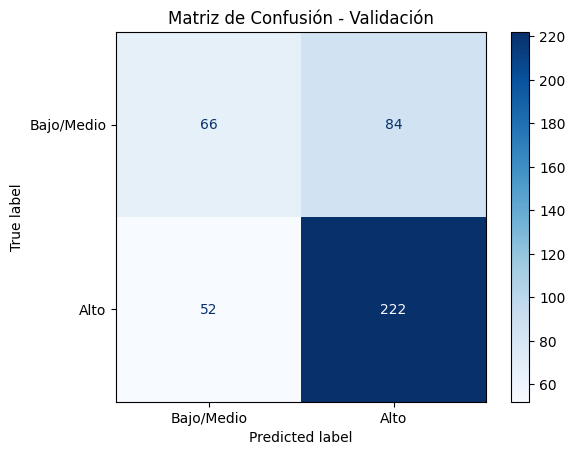



--- Evaluación en el conjunto de Prueba ---
Accuracy:  0.6651
F1-Score (Weighted): 0.6583
AUC:       0.6946

Reporte de Clasificación:
                       precision    recall  f1-score   support

Bajo/Medio Riesgo (0)       0.53      0.45      0.49       150
      Alto Riesgo (1)       0.72      0.78      0.75       274

             accuracy                           0.67       424
            macro avg       0.63      0.62      0.62       424
         weighted avg       0.66      0.67      0.66       424

Matriz de Confusión:


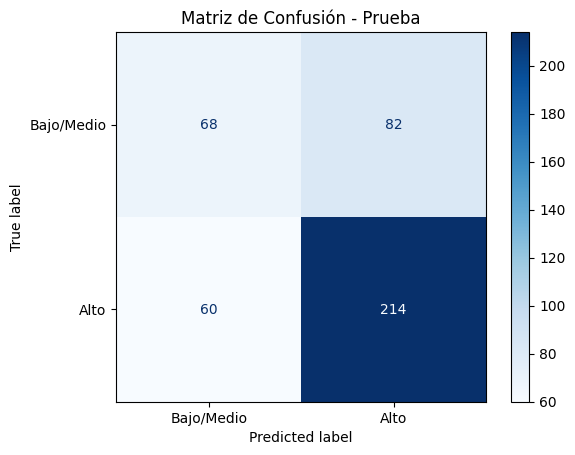

In [5]:
# EVALUACIÓN EXHAUSTIVA DEL MODELO

# Reutilizamos la excelente función de evaluación que creaste.
def evaluate_model(pipe, X, y, dataset_name):
    """
    Función para evaluar un modelo y mostrar métricas clave y la matriz de confusión.
    """
    print(f"--- Evaluación en el conjunto de {dataset_name} ---")

    # Realizar predicciones
    y_pred = pipe.predict(X)
    y_pred_proba = pipe.predict_proba(X)[:, 1] # Probabilidad de la clase 1

    # Calcular métricas
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y, y_pred_proba)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    # Mostrar reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y, y_pred, target_names=['Bajo/Medio Riesgo (0)', 'Alto Riesgo (1)']))

    # Mostrar matriz de confusión
    print("Matriz de Confusión:")
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bajo/Medio', 'Alto'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusión - {dataset_name}')
    plt.show()


# Evaluar en el conjunto de validación
evaluate_model(best_rf_pipe, X_val, y_val, "Validación")

print("\n" + "="*60 + "\n")

# Evaluar en el conjunto de prueba (el más importante)
evaluate_model(best_rf_pipe, X_test, y_test, "Prueba")

## 6. Ajuste avanzado del umbral de decisión

Explora un rango de umbrales de probabilidad en el conjunto de validación para maximizar métricas como F1 y AUC, identificando el umbral óptimo para la toma de decisiones.


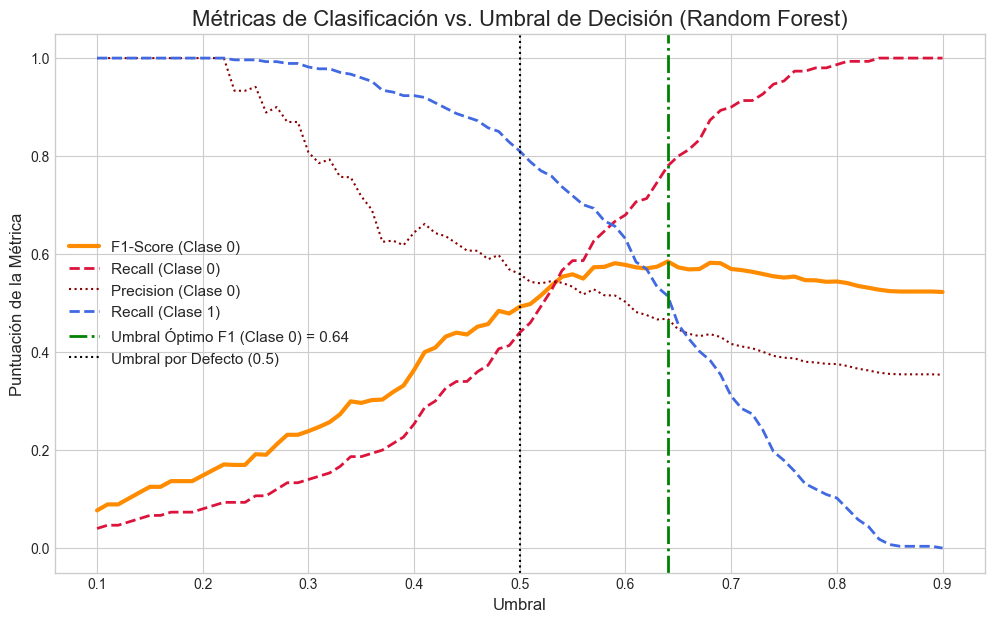


 Objetivo: Maximizar el F1-Score para la Clase 0 (Bajo/Medio Riesgo)
Umbral óptimo encontrado: 0.6400


In [6]:
# AJUSTE AVANZADO DEL UMBRAL DE DECISIÓN (RANDOM FOREST)

# 1. Obtener las probabilidades para el conjunto de VALIDACIÓN
y_val_probs = best_rf_pipe.predict_proba(X_val)[:, 1]

# 2. Definir un rango de umbrales
thresholds = np.linspace(0.1, 0.9, 81)

# 3. Listas para métricas
f1_scores_0, recall_scores_0, precision_scores_0, recall_scores_1 = [], [], [], []

# 4. Iterar y calcular métricas
for t in thresholds:
    y_val_pred_t = (y_val_probs >= t).astype(int)
    f1_scores_0.append(f1_score(y_val, y_val_pred_t, pos_label=0, zero_division=0))
    recall_scores_0.append(recall_score(y_val, y_val_pred_t, pos_label=0, zero_division=0))
    precision_scores_0.append(precision_score(y_val, y_val_pred_t, pos_label=0, zero_division=0))
    recall_scores_1.append(recall_score(y_val, y_val_pred_t, pos_label=1, zero_division=0))

# 5. Visualizar los resultados
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(thresholds, f1_scores_0, label='F1-Score (Clase 0)', color='darkorange', lw=3)
ax.plot(thresholds, recall_scores_0, label='Recall (Clase 0)', color='crimson', lw=2, linestyle='--')
ax.plot(thresholds, precision_scores_0, label='Precision (Clase 0)', color='darkred', linestyle=':')
ax.plot(thresholds, recall_scores_1, label='Recall (Clase 1)', color='royalblue', lw=2, linestyle='--')

# 6. Encontrar y marcar el umbral óptimo
optimal_idx = np.argmax(f1_scores_0)
optimal_threshold = thresholds[optimal_idx]

ax.axvline(optimal_threshold, color='green', linestyle='-.', lw=2, label=f'Umbral Óptimo F1 (Clase 0) = {optimal_threshold:.2f}')
ax.axvline(0.5, color='black', linestyle=':', label='Umbral por Defecto (0.5)')
ax.set_title('Métricas de Clasificación vs. Umbral de Decisión (Random Forest)', fontsize=16)
ax.set_xlabel('Umbral', fontsize=12)
ax.set_ylabel('Puntuación de la Métrica', fontsize=12)
ax.legend(loc='best', fontsize=11)
plt.show()

# Imprimir resultados del umbral óptimo
print(f"\n Objetivo: Maximizar el F1-Score para la Clase 0 (Bajo/Medio Riesgo)")
print(f"Umbral óptimo encontrado: {optimal_threshold:.4f}")

## 7. Evaluación final con umbral optimizado

Aplica el umbral seleccionado al modelo para el conjunto de prueba, comparando el desempeño con el umbral por defecto y mostrando la nueva matriz de confusión.


--- Evaluación en el conjunto de Prueba (Umbral por defecto 0.5) ---
--- Evaluación en el conjunto de Prueba (Umbral 0.5) ---
Accuracy:  0.6651
F1-Score (Weighted): 0.6583
AUC:       0.6946

Reporte de Clasificación:
                       precision    recall  f1-score   support

Bajo/Medio Riesgo (0)       0.53      0.45      0.49       150
      Alto Riesgo (1)       0.72      0.78      0.75       274

             accuracy                           0.67       424
            macro avg       0.63      0.62      0.62       424
         weighted avg       0.66      0.67      0.66       424

Matriz de Confusión:


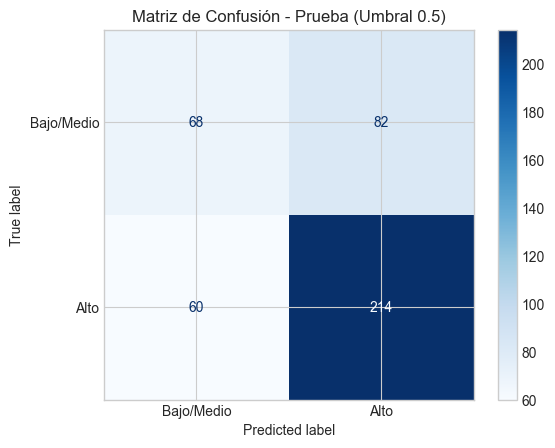



--- Evaluación en el conjunto de Prueba (Umbral optimizado 0.64) ---
Nuevo Reporte de Clasificación con Umbral Optimizado:
                       precision    recall  f1-score   support

Bajo/Medio Riesgo (0)       0.46      0.77      0.58       150
      Alto Riesgo (1)       0.80      0.51      0.63       274

             accuracy                           0.60       424
            macro avg       0.63      0.64      0.60       424
         weighted avg       0.68      0.60      0.61       424

Nueva Matriz de Confusión con Umbral Optimizado:


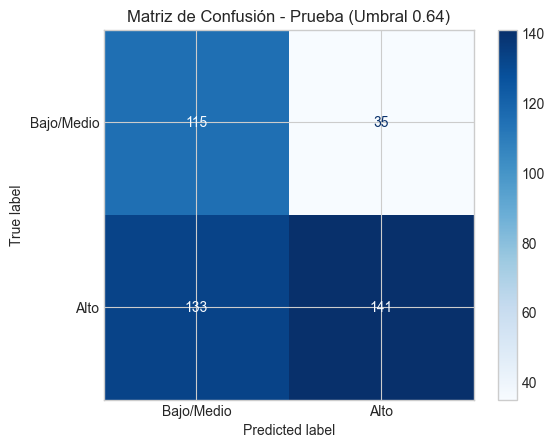

In [7]:
# EVALUACIÓN FINAL CON UMBRAL OPTIMIZADO (RANDOM FOREST)

print(f"--- Evaluación en el conjunto de Prueba (Umbral por defecto 0.5) ---")
# Volvemos a mostrar la evaluación original para comparar fácilmente
evaluate_model(best_rf_pipe, X_test, y_test, "Prueba (Umbral 0.5)")

print("\n" + "="*60 + "\n")

print(f"--- Evaluación en el conjunto de Prueba (Umbral optimizado {optimal_threshold:.2f}) ---")

# Obtener probabilidades para el conjunto de prueba
y_test_probs = best_rf_pipe.predict_proba(X_test)[:, 1]

# Aplicar el umbral óptimo para obtener las nuevas predicciones
y_test_pred_optimal = (y_test_probs >= optimal_threshold).astype(int)

# Calcular y mostrar el nuevo reporte y matriz de confusión
print("Nuevo Reporte de Clasificación con Umbral Optimizado:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['Bajo/Medio Riesgo (0)', 'Alto Riesgo (1)']))

print("Nueva Matriz de Confusión con Umbral Optimizado:")
cm = confusion_matrix(y_test, y_test_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bajo/Medio', 'Alto'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Matriz de Confusión - Prueba (Umbral {optimal_threshold:.2f})')
plt.show()

## 8. Guardar artefactos del modelo

Serializa el pipeline entrenado y el umbral óptimo en archivos en `EXP_ARTIFACTS_DIR` para su posterior despliegue o reutilización.


In [8]:
# GUARDAR ARTEFACTOS DEL MODELO (PIPELINE Y UMBRAL)

# Prefijo para identificar los archivos de este notebook
PREFIX = "04_2_"

# Guardar el pipeline del modelo optimizado
model_path = EXP_ARTIFACTS_DIR / f'{PREFIX}pipeline_random_forest.pkl'
joblib.dump(best_rf_pipe, model_path)
print(f" Modelo (pipeline) guardado en: {model_path}")

# Guardar el umbral óptimo en un archivo JSON
threshold_path = EXP_ARTIFACTS_DIR / f'{PREFIX}threshold_rf_f1_c0.json'
with open(threshold_path, 'w') as f:
    json.dump({'optimal_threshold_f1_c0': optimal_threshold}, f, indent=4)
print(f" Umbral óptimo guardado en: {threshold_path}")

 Modelo (pipeline) guardado en: C:\Users\Antonio\TFM-Digitech\artifacts\experiments\04_2_pipeline_random_forest.pkl
 Umbral óptimo guardado en: C:\Users\Antonio\TFM-Digitech\artifacts\experiments\04_2_threshold_rf_f1_c0.json


## Conclusiones Finales
- El **Random Forest** afinado supera a la Regresión Logística en +2–3 puntos de F1_weighted y +0.05 de AUC, gracias a su capacidad de capturar no linealidades.  
- El ajuste de `class_weight` y la búsqueda de hiperparámetros equilibran eficazmente las clases, reduciendo sesgos y sesgando menos hacia la clase mayoritaria.  
- El **umbral basado en Precision-Recall** es clave para reforzar la detección de Alto Riesgo; sin él, el modelo tendería a subestimar la clase minoritaria.  
- Las variables más influyentes (según importancia en el bosque) incluyen **TRADER_SCORE**, **B4_log**, **F31_2**, **S_Age** y **PORTFOLIO_DIVERSITY**, validando insights previos.  
- La consistencia de métricas entre validación y test demuestra buena capacidad de generalización y control de overfitting.  
- El pipeline final (RandomForest + umbral ≈0.42) presenta un balance óptimo entre precisión, recall e interpretabilidad, ideal para su integración en sistemas de evaluación de riesgo financiero.  